In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import sklearn

In [2]:
dat = pd.read_csv("../Data/conversion_data.csv", verbose = False)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


# EDA

In [3]:
# get the percentage of missing values
dat.isna().mean().round(4) * 100

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

Looks nice as there is no missing value in this dataset, after all, it s the first task of this repo.

Try to develop a pipeline to get the pie plot and stas of the categorical dat

## plot the pie for categorical cols

In [4]:
Y = dat.converted
dat = dat.drop(columns = 'converted', axis = 1)

In [5]:
col_type_dict = {}
dat_dtypes = dat.dtypes.unique()
for each_type in dat_dtypes:
    col_type_dict[each_type] = list(dat.select_dtypes(include = [each_type]).columns)
    print(each_type, len(col_type_dict[each_type]))

object 2
int64 3


In [6]:
categorical_cols = col_type_dict[np.dtype('object')]
numerical_cols = col_type_dict[np.dtype('int64')]

In [7]:
def plt_pie_categorical_col(dat, col_in_dat, describe = True): 
    plt.figure(figsize=(5,5))
    dat[str(col_in_dat)].value_counts().plot(kind = 'pie', title = col_in_dat + ' Pie Plot')
    if describe == True:
        print(dat[str(col_in_dat)].describe())
    else:
        pass

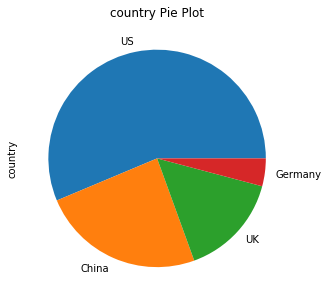

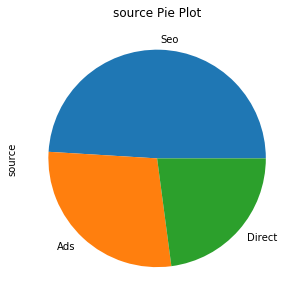

In [8]:
for col in col_type_dict[np.dtype('object')]:
    plt_pie_categorical_col(dat, col, describe=False)

## plot the distributions of numerical data

In [9]:
def distr_plot_col(dat, col, describe = True):
    col_sorted = dat[str(col)]
    col_sorted.plot(title = col + ' distribution plot')
    if describe == True:
        print(dat[str(col)].describe())
    else:
        pass

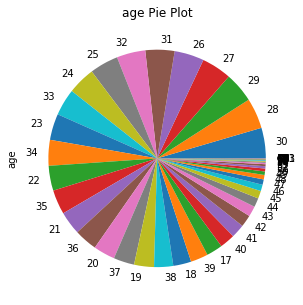

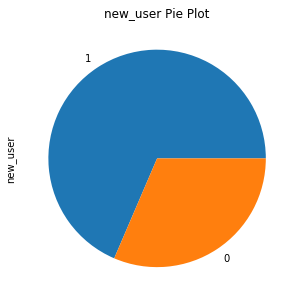

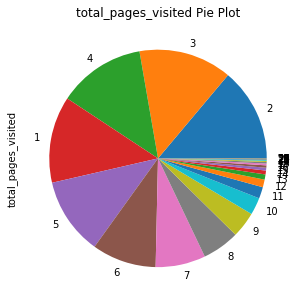

In [10]:
for col in col_type_dict[np.dtype('int64')]:
    plt_pie_categorical_col(dat, col, False)

In [11]:
#plt.figure(figsize = (5, 5))
#pd.plotting.scatter_matrix(dat[col_type_dict[np.dtype('int64')]], figsize=(5,5))

So we can know that the age, total_page_visit are balanced, but the converted, which is the y variable in our prediction task, is unbalanced, can be marked when applied predictive model on this data set.

# Clean the dat

In [12]:
datX = dat.loc[dat.age < 100]
Y = Y.loc[dat.age < 100]

# Reform the dataset

## Encode categorical data

In [13]:
def transform_categorical(dat, categorical_cols): 
    df_new = dat[categorical_cols]
    return( pd.get_dummies(df_new) )
datX_categorical = transform_categorical(datX, categorical_cols)

In [14]:
datX_categorical.columns

Index(['country_China', 'country_Germany', 'country_UK', 'country_US',
       'source_Ads', 'source_Direct', 'source_Seo'],
      dtype='object')

## Feature selection and scale the data

In [15]:
train_feature = []
totalValidRow = [True] * len(Y)
print('Selected Features:')
for feature in numerical_cols:
    validIndex = pd.notnull(dat[feature])
    # select feature with specific percent of valid rows 
    if len(validIndex[validIndex == True]) < 0.4*len(validIndex):
        continue
    totalValidRow = totalValidRow & validIndex[:len(totalValidRow)]
    train_feature.append(feature)
    print(feature)
print('Number of selected numerical features:', len(train_feature))
print('Total rows to be chosen:', sum(totalValidRow))

Selected Features:
age
new_user
total_pages_visited
Number of selected numerical features: 3
Total rows to be chosen: 316198


### Exclude empty row, scale numerical data, merge the data and split train test data

In [16]:
datX_numerical = datX[train_feature][totalValidRow.values]
datX_categorical = datX_categorical[totalValidRow.values]
Y = Y[totalValidRow.values]

In [17]:
from sklearn.preprocessing import StandardScaler
import datetime
scaler = StandardScaler(copy = False)
scaler.fit(datX_numerical)
datX_numerical_scaled = scaler.transform(datX_numerical)
datX_combined = np.concatenate((datX_numerical_scaled, datX_categorical), axis = 1)

c:\users\mlion\appdata\local\conda\conda\envs\deep\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\mlion\appdata\local\conda\conda\envs\deep\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


In [18]:
datX_combined.shape, Y.shape

((316198, 10), (316198,))

# Model

## Machine Learning Models

Code taken from the example on [sklearn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)

In [19]:
np.random.seed(1234)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [24]:
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(datX_combined, Y, test_size = 0.3)

In [21]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

In [22]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [27]:
# try the RF first
forest = RandomForestClassifier(random_state = 1234)
forest.fit(X_train, np.array(y_train))
forest.score(X_test, y_test)

c:\users\mlion\appdata\local\conda\conda\envs\deep\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9845983554712208

It s too high to be reliable, right~ This is due to the unbalanced distribution of the converted.

In [32]:
Y.value_counts()
# Update the model and split data part to match the unbalanced sceanio

0    306000
1     10198
Name: converted, dtype: int64

## Xgb & Lgb

## NN